In [ ]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast
import pandas as pd
from global_model_periodic import LearnedSimulator_periodic
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')

In [3]:
def voronoi_polygon_periodic(centers, target_indices):
    """
    Calcule les cellules de Voronoi uniquement pour les n_main premiers centres,
    entourés de duplications périodiques des autres.
    """
    init_square = torch.tensor([
        [-10.0, -10.0],
        [10.0, -10.0],
        [10.0, 10.0],
        [-10.0, 10.0],
    ], dtype=torch.float32, device=centers.device)

    vor_polygons = []

    for i in target_indices:  # uniquement les centres principaux
        center = centers[i]
        polygon = init_square.clone()

        for j, neighbor in enumerate(centers):
            if i == j:
                continue
            midpoint = (center + neighbor) / 2
            direction = neighbor - center
            polygon = clip_polygon(polygon, midpoint, direction)
            if len(polygon) == 0:
                break

        if len(polygon) >= 3:
            vor_polygons.append(torch.stack(polygon))
        else:
            vor_polygons.append(torch.empty((0, 2), device=centers.device))

    return vor_polygons

def compute_half_plane(center, neighbor):
    """Retourne le vecteur normal et un point sur la bissectrice entre center et neighbor."""
    midpoint = (center + neighbor) / 2
    direction = neighbor - center
    return midpoint,direction

def clip_polygon(polygon, midpoint,original_direction):
    """Clippe un polygone avec un demi-plan défini par un point et une normale."""
    new_polygon = []
    prev_vertex = polygon[-1]
    prev_inside = torch.dot(prev_vertex - midpoint, original_direction) <= 0
    for curr_vertex in polygon:
        curr_inside = torch.dot(curr_vertex - midpoint, original_direction) <= 0
        if curr_inside:
            if not prev_inside:
                direction = curr_vertex - prev_vertex
                denom = torch.dot(direction, original_direction)
                if denom != 0:
                    t = torch.dot(midpoint - prev_vertex, original_direction) / denom
                    inter = prev_vertex + t * direction
                    new_polygon.append(inter)
            new_polygon.append(curr_vertex)
        elif prev_inside:
            direction = curr_vertex - prev_vertex
            denom = torch.dot(direction, original_direction)
            if denom != 0:
                t = torch.dot(midpoint - prev_vertex, original_direction) / denom
                inter = prev_vertex + t * direction
                new_polygon.append(inter)
        prev_vertex = curr_vertex
        prev_inside = curr_inside
    return new_polygon if len(new_polygon) >= 3 else []


def polygon_area(polygon):
        x = polygon[:, 0]
        y = polygon[:, 1]
        return 0.5 * torch.abs(torch.dot(x, torch.roll(y, -1)) - torch.dot(y, torch.roll(x, -1)))

def polygon_perimeter(polygon):
    return torch.sum(torch.norm(polygon - torch.roll(polygon, -1, dims=0), dim=1))

In [4]:
def voronoi_loss(output,target_indices,accelerations,target_areas= 0.4,masse = 0.1, dt = 0.05):
    vor_polygons = voronoi_polygon_periodic(output,target_indices)
    areas = []
    perimeters = []
    min_val = torch.tensor(1e-6, device=output.device)
    for poly in vor_polygons:
        if poly.shape[0] >= 3:
            areas.append(polygon_area(poly))
            perimeters.append(polygon_perimeter(poly))
        else:
            areas.append(min_val)
            perimeters.append(min_val)

    areas_tensor = torch.stack(areas)
    perimeters_tensor = torch.stack(perimeters)
    physics_loss = torch.sum(0.02*(target_areas - areas_tensor)**2 + 0.000*perimeters_tensor+1e-5*(target_areas/(areas_tensor))**2)
    kinetic_loss = torch.sum((0.5*masse*dt**2)*(accelerations/(dt**2))**2)
    return physics_loss+kinetic_loss

In [5]:
def loss_complete(acceleration, target,output,target_indices):
    physics_loss = voronoi_loss(output,target_indices,acceleration)
    return physics_loss

In [6]:
class TrajectoryDataset(Dataset):
    def __init__(self, csv_file_paths, step, seq_len=5, noise_std=0.0):
        self.samples = []
        self.seq_len = seq_len
        self.noise_std = noise_std

        for i in range(41,46):
            csvpath = csv_file_paths + str(i) + ".csv"
            df = pd.read_csv(
                csvpath,
                dtype={"x": np.float32, "y": np.float32, "step": np.int32, "site_index": np.int32}
            )
            

            df_grouped = df.groupby('step')
            clean_positions = []

            for step_id, data in df_grouped:
                if step_id < step:
                    data_sorted = data.sort_values('site_index')
                    np_data = data_sorted[['x', 'y']].to_numpy(dtype=np.float32)
                    pos = torch.from_numpy(np_data) 
                    clean_positions.append(pos)

            for t in range(seq_len - 1, len(clean_positions)):
                # séquence des N dernières positions
                input_seq = clean_positions[t - seq_len + 1: t + 1] 
                input_seq_tensor = torch.stack(input_seq)
                x_t2 = input_seq[-3]
                x_t1 = input_seq[-2]
                x_t = input_seq[-1]
                acc = x_t - 2 * x_t1 + x_t2
                def noisy(x): 
                    return x + torch.randn_like(x) * self.noise_std if self.noise_std > 0 else x

                input_seq_noisy = torch.stack([noisy(x) for x in input_seq])
                self.samples.append((input_seq_noisy, acc))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [7]:
def generate_next_positions(model, device, vrai_pos,n_cells):
    model.eval()
    pos = vrai_pos.copy()
    x = torch.tensor(np.stack(pos, axis=1), dtype=torch.float).to(device)
    next_position, acc = model(x,n_cells)
    for i in range(len(pos)-1):
        pos[i] = pos[i+1].copy()
    pos[-1] = next_position.cpu().detach().numpy()
    return pos,acc

In [8]:
def avg_test(model,device,csv_file,n_cells):
    loss = 0
    csvpath = csv_file + str(46) +".csv" 
    df = pd.read_csv(csvpath)
    steps_list = df["step"].unique()
    pos = []
    loss_fn = loss_complete
    vrai_pos = []
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions)
        vrai_pos.append(positions)
    for step in steps_list[5:20]:
        pos,acc = generate_next_positions(model, device, vrai_pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
            vrai_pos[i] = vrai_pos[i+1].copy() 
        vrai_pos[-1] = positions.copy()
        loss+=loss_fn(acc,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float).to(device),torch.tensor(pos[-1], dtype=torch.float).to(device),np.arange(n_cells)).item()
    return loss/15
        

In [9]:
def train_gnn_optimized(model, csv_files, loss_fn, epochs=11, lr=1e-4, batch_size=32, seq_len=5, noise_std=0.0, device='cuda'):
    model = model.to(device)
    model = torch.compile(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    n_cells = 10
    print("Loading dataset...")
    start = time.perf_counter()
    dataset = TrajectoryDataset(csv_files, step=20, seq_len=seq_len, noise_std=noise_std)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Dataset loaded in {time.perf_counter() - start:.2f} seconds")
    
    model.train()
    train_loss = []
    test_loss = []

    for epoch in tqdm(range(epochs)):
        total_loss = 0
        total_batches = 0
        for x_seq, acc in dataloader:
            x_seq = x_seq.to(device)
            acc = acc.to(device).squeeze(0)
            acc =acc[:n_cells]
            input_traj = x_seq.permute(0, 2, 1, 3).squeeze(0) 
            optimizer.zero_grad()
            with autocast(device_type='cuda',enabled=False):
                output, pred_acc = model(input_traj,n_cells)
                loss = loss_fn(pred_acc, acc, output,np.arange(n_cells))
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_batches += 1

        avg_loss = total_loss / total_batches if total_batches > 0 else 0

        if epoch % 10 == 0:
            model.eval()
            train_loss.append(avg_loss)
            print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.6f}")
            test_l = avg_test(model, device, csv_files,n_cells)
            test_loss.append(test_l)
            print(f"Test Loss: {test_l:.6f}")
            model.train()
            print(acc,pred_acc)
            # Save model and loss
            path_prefix = "/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Unsupervised/Training/phy_noise_4Conv_256_new_data/"
            torch.save(model.state_dict(), path_prefix + f"model_{epoch}.pth")
            loss_df = pd.DataFrame({
                "epoch": list(range(len(train_loss))),
                "global_loss": train_loss,
                "test_loss": test_loss
            })
            loss_df.to_csv(path_prefix + f"loss_{epoch}.csv", index=False)

    return model, train_loss, test_loss


In [10]:
normalization_stats = {
    "velocity": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)},
    "acceleration": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e0, 1e0]).to(device)}
}

In [11]:
model = LearnedSimulator_periodic(num_dimensions=2, normalization_stats=normalization_stats, device=device)
model.to(device)
trained_model, train_loss, test_loss = train_gnn_optimized(
    model=model,
    csv_files="/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/data/positions_",
    loss_fn=loss_complete,
    epochs= 541,
    lr=1e-5,
    batch_size=1,
    seq_len=5,
    noise_std=0.0001,
    device='cuda'
)


Loading dataset...
Dataset loaded in 0.15 seconds


  0%|          | 0/541 [00:00<?, ?it/s]W0708 14:28:16.486000 1385149 torch/_dynamo/convert_frame.py:964] [6/8] torch._dynamo hit config.recompile_limit (8)
W0708 14:28:16.486000 1385149 torch/_dynamo/convert_frame.py:964] [6/8]    function: 'compute_polygon_area_and_perimeter' (/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Unsupervised/Model/global_model_periodic.py:34)
W0708 14:28:16.486000 1385149 torch/_dynamo/convert_frame.py:964] [6/8]    last reason: 6/4: len(polygon) == 4                                      
W0708 14:28:16.486000 1385149 torch/_dynamo/convert_frame.py:964] [6/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0708 14:28:16.486000 1385149 torch/_dynamo/convert_frame.py:964] [6/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
  0%|          | 0/541 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(train_loss, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.title('Avg Loss')
plt.show()

NameError: name 'train_loss' is not defined

[0.0018563881904507676, 0.0018439540717129907, 0.0018439544597640633, 0.0018439549952745438, 0.0018439559343581399, 0.0018439538932094972, 0.0018439572770148516, 0.0018439754533270995, 0.0018440282981221875, 0.0018440133503948648, 0.0018440208475415905, 0.0018439944290245573, 0.001844172024478515, 0.0018444255304833253, 0.0018444386000434558, 0.001844227119969825, 0.001844306072841088, 0.0018440225549663106, 0.0018440558419873317, 0.0018443796473244826, 0.0018440786749124526, 0.0018440098191301027, 0.001844102671990792, 0.001844111162548264, 0.001844141430531939, 0.0018440694625799854, 0.0018441640849535665, 0.0018440186356504758, 0.0018442553390438357, 0.0018442807874331872, 0.0018444980261847377, 0.0018447668912510077, 0.0018450251004348199, 0.0018444878437245886, 0.0018453361078475913, 0.0018441088420028489, 0.001844145132539173, 0.0018445367459207773, 0.0018445724000533423, 0.0018442827820157011, 0.0018445736107726891, 0.0018441842558483282, 0.0018448258517310024, 0.001845809731942

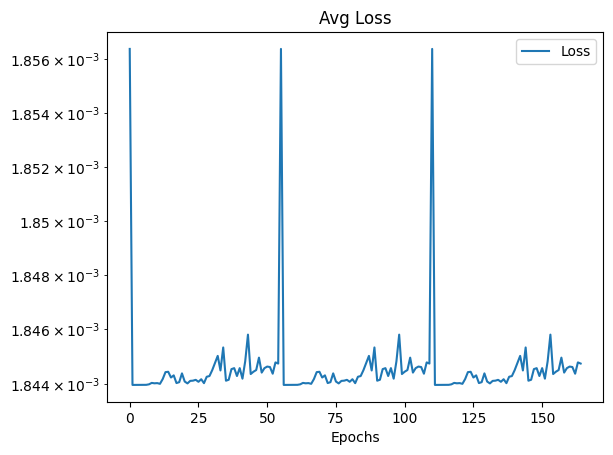

In [ ]:
plt.plot(test_loss, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.title('Avg Loss')
plt.show()

In [ ]:
def create_csv_with_predictions(model,n_cells, device, input_csv,steps=205):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    pos = []
    loss_fn = nn.MSELoss()
    vrai_pos = []
    norm_acc = []
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, vrai_pos,n_cells)
        # print(rot_pos)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
             vrai_pos[i] = vrai_pos[i+1].copy()
        vrai_pos[-1] = positions.copy()
        print(acc,(vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells])
        if step%1==0:
            norm_acc.append(np.linalg.norm((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[0]))
            print(loss_fn(acc,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).item())
            loss.append(loss_fn(acc,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).item())
    return loss,norm_acc

In [ ]:
loss,acc = create_csv_with_predictions(model,10, device, "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/data/positions_41.csv",205)

tensor([[-1.7519e-04, -4.4597e-05],
        [-1.5542e-05, -1.0146e-04],
        [-2.7109e-04,  5.6850e-05],
        [-1.8857e-05, -1.3377e-04],
        [-4.7418e-04, -4.4483e-04],
        [-2.1021e-04, -2.4381e-04],
        [-1.5709e-04,  4.1546e-05],
        [-7.1600e-06,  1.4873e-04],
        [ 1.7025e-06,  7.1703e-05],
        [-1.4834e-04,  1.7109e-04]], device='cuda:0', grad_fn=<AddmmBackward0>) [[ 5.4964000e-06 -1.4775370e-04]
 [ 2.4519400e-05  5.9499900e-05]
 [-1.4085400e-05  5.3166600e-05]
 [-7.1302800e-05 -6.2937800e-05]
 [-6.9340000e-05 -3.1583280e-04]
 [ 2.0800980e-05 -8.4513200e-05]
 [ 8.3311500e-05  1.2146717e-04]
 [ 9.3753000e-05  1.3319070e-04]
 [-6.1131000e-06  1.5416230e-04]
 [-6.7039800e-05  8.9550600e-05]]
2.4931841480224648e-08
tensor([[-9.1322e-05, -1.7670e-04],
        [-9.6638e-05, -6.8998e-05],
        [-2.1649e-04,  6.0035e-05],
        [-1.6057e-04, -9.8567e-05],
        [-3.1770e-04, -3.6727e-04],
        [-1.4507e-04, -3.4419e-04],
        [ 9.8445e-05,  4.1

270.17456574185417


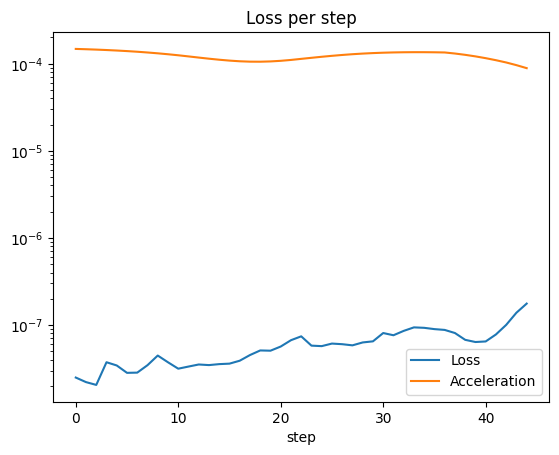

In [ ]:
plt.plot(loss, label='Loss')
plt.plot(acc, label='Acceleration')
plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()

In [ ]:
def create_csv_with_real_predictions(model,n_cells, device, input_csv, output_csv, steps=205):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    results = []
    pos = []
    vrai_pos = []
    loss_fn = nn.MSELoss()
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, vrai_pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
             vrai_pos[i] = vrai_pos[i+1].copy()
        vrai_pos[-1] = positions.copy()
        print(acc,(vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells])
        if step%10==0:
            loss.append(loss_fn(acc,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).cpu().detach().numpy())
        for id_, positions in enumerate(pos[-1]):
                results.append({"step": step, "site_index": id_, "x": positions[0], "y": positions[1]})
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
    return loss

In [ ]:
loss = create_csv_with_real_predictions(model,10, device, "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/data/positions_48.csv", "/home/jeanlienhard/Documents/CellGNN/test_gnn/model_Cell/positions/computed_positions_48.csv",205)

tensor([[-1.0032e-05,  1.4387e-05],
        [-6.2510e-05,  1.2776e-04],
        [-4.1950e-04,  1.2146e-05],
        [-1.7562e-04, -3.0266e-05],
        [-5.3145e-04,  1.2877e-04],
        [-1.0976e-04, -3.8175e-05],
        [-1.8123e-04, -1.0481e-05],
        [-1.4001e-04,  8.0410e-06],
        [-1.6178e-04,  9.6221e-05],
        [-8.5011e-05, -1.1345e-05]], device='cuda:0', grad_fn=<AddmmBackward0>) [[ 1.167567e-04  4.502780e-05]
 [-1.120603e-04  2.227420e-04]
 [-1.292060e-05  1.124546e-04]
 [-1.526121e-04  8.953030e-05]
 [-1.245825e-04 -2.559702e-04]
 [ 1.449568e-04 -5.473160e-05]
 [-9.770000e-08 -7.682200e-05]
 [ 3.179800e-05 -2.662860e-05]
 [ 7.472100e-05 -7.375139e-05]
 [ 3.404116e-05  1.814900e-05]]
tensor([[-2.5740e-04, -6.1767e-05],
        [-1.5937e-04, -4.4683e-05],
        [-1.5920e-04, -5.7889e-05],
        [-3.7205e-04,  1.6512e-04],
        [-5.9914e-04, -8.3242e-06],
        [-1.4296e-04, -1.4294e-04],
        [-2.9776e-04, -3.4343e-05],
        [-2.3891e-04,  1.8049e-06